In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
import h5py
import mat73
import nbimporter
from _create_pdf import create_spins
from _helper_functions import tsallis, cauchy, find_nearest_index, correct_for_fano, replace_in_file
from _steady_state import cav_steady, cav_steady_fano, cav_steady_fano2
import _spin_params as spin_params
# %qtconsole

In [2]:
quali = 4000
fres = 3230
kappa = np.pi*fres/quali  # HWHM
deltac = 0*2*np.pi  # detuning drive to cavity wc-wp
nbins = 701  # 701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

2.536836067773758


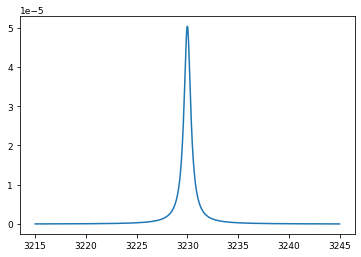

In [3]:
initsteady = (0.1, 0.1)
fstart = 15
deltaarr = fres+np.linspace(-fstart, fstart, 2001)
ampl = 1.8e-2

ar, ai = cav_steady(deltaarr*2*np.pi, fres*2*np.pi,  ampl, kappa)
losasteady = ai**2+ar**2


fig = plt.figure()
plt.plot(deltaarr, losasteady)
# plt.grid(True)
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [4]:
filepath = "%s/%s" % (spin_params.folder, spin_params.reference_trace)

exp = {}
traceidx = 0
try:
    data = mat73.loadmat(filepath)
except TypeError:
    data = scipy.io.loadmat(filepath, simplify_cells=True)


data = data['hipowTrace']


imagpart = data['imagpart']
realpart = data['realpart']
freqStart = data['freqStart']
freqStop = data['freqStop']
numPoints = data['numPoints']


freqs = (np.linspace(freqStart, freqStop, numPoints)) * \
    1e-6  # -(freqstart+freqstop)/2)*1e-6#-1.38
power = np.squeeze(imagpart**2+realpart**2)

### Fit Cavity

In [5]:
cavity_sign = -1


def fitfunc(freqs, fres, ampl, kappa, offset, phi, dt, phi_offset):
    freqsin = freqs[:int(len(freqs)/2)]
    if cavity_sign == -1:
        ar, ai = cav_steady_fano2(freqsin*2*np.pi, fres*2 *
                                  np.pi,  ampl, kappa, phi, dt/fres, offset, phi_offset)
    else:
        ar, ai = cav_steady_fano(freqsin*2*np.pi, fres*2 *
                                 np.pi,  ampl, kappa, phi, dt/fres, offset, phi_offset)
    losasteady = np.hstack((ar, ai))
    return losasteady


p0 = [3.09758244e+03, 3.56179016e-01, 3.97217694e+00, -1.06785539e-03,
      6, 1.74434398e+02, 5.93578702e-01]
bounds = ((0, 0, -np.inf, -np.inf, 0, 0, 0),
          (np.inf, np.inf, np.inf, np.inf, 2*np.pi, np.inf, 2*np.pi))
popt, pcov = scipy.optimize.curve_fit(fitfunc, np.hstack((freqs, freqs)), np.hstack((realpart, imagpart)), p0=p0, maxfev=10000,
                                      bounds=bounds)


def fitfunc_dt(freqs, phi, dt, phi_offset): return fitfunc(
    freqs, popt[0], popt[1], popt[2], popt[3], phi, dt, phi_offset)


dtbest, pcov = scipy.optimize.curve_fit(fitfunc_dt, np.hstack(
    (freqs, freqs)), np.hstack((realpart, imagpart)), p0=(popt[4], popt[5], popt[6]), maxfev=10000)

popt[4:] = dtbest
print(popt)

[ 3.09978892e+03  3.73968678e-01  7.14012477e+00 -9.44427526e-04
  8.27630285e+00  1.74346332e+02  7.74061747e-01]


Resonance frequency: 3099.7889 MHz
Kappa (HWHM): 7.14 MHz
Quality Factor: 1363.88
Offset: -0.000944427526
Phase Offset: 0.774061746743
Phase: 8.276302849185
Running Phase: 0.056244582037


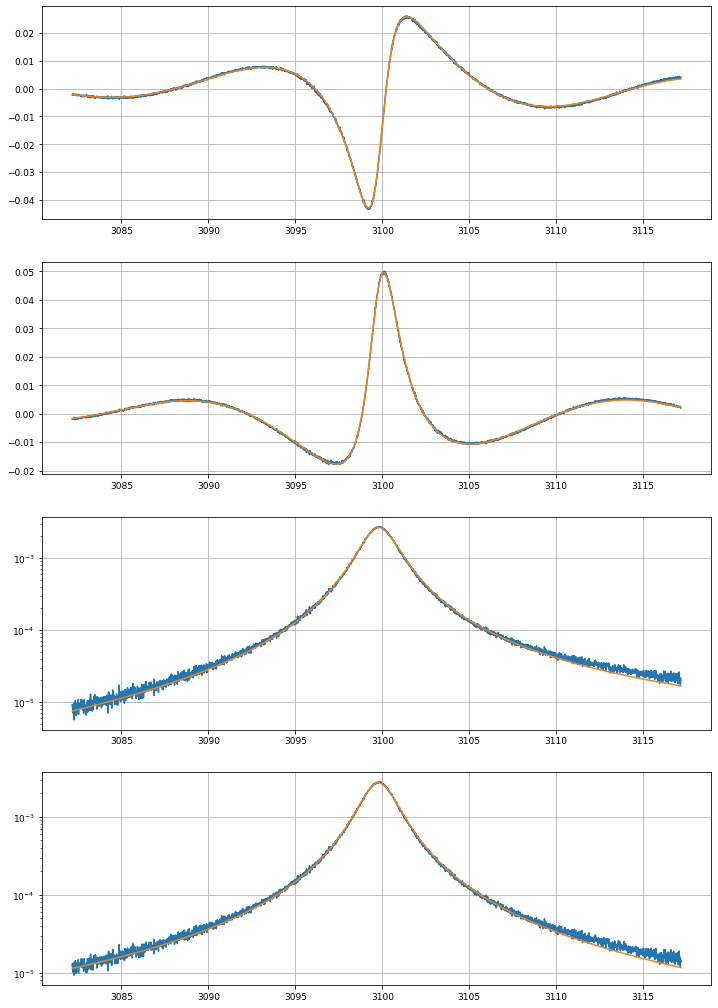

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 18))

fitres = fitfunc(np.hstack((freqs, freqs)), *popt)
refit = fitres[:int(len(fitres)/2)]
imfit = fitres[int(len(fitres)/2):]

ax1.plot(freqs, realpart)
ax1.plot(freqs, refit)
ax1.grid(True)

ax2.plot(freqs, imagpart)
ax2.plot(freqs, imfit)
ax2.grid(True)

ax3.semilogy(freqs, imagpart**2+realpart**2)
ax3.plot(freqs, imfit**2+refit**2)
ax3.grid(True)

offset = popt[3]
phi_offset = popt[6]
phi = popt[4]
dt = popt[5]/popt[0]


corrected_real, corrected_imag = correct_for_fano(
    freqs*2*np.pi, realpart, imagpart, phi, dt, offset, phi_offset)

fit_corr_real, fit_corr_imag = cav_steady(
    freqs*2*np.pi, popt[0]*2*np.pi, popt[1], popt[2])

ax4.semilogy(freqs, corrected_imag**2+corrected_real**2)
ax4.plot(freqs, fit_corr_real**2+fit_corr_imag**2)
ax4.grid(True)
print('Resonance frequency: %.4f MHz' % popt[0])
print('Kappa (HWHM): %.2f MHz' % (popt[2]))
print('Quality Factor: %.2f' % np.abs(np.pi*popt[0]/popt[2]))
print('Offset: %.12f' % popt[3])
print('Phase Offset: %.12f' % popt[6])
print('Phase: %.12f' % popt[4])
print('Running Phase: %.12f' % dt)

In [7]:
# replace all the values in the spin_params file
replace_in_file("./_spin_params.py", "quali", np.abs(np.pi*popt[0]/popt[2]))
replace_in_file("./_spin_params.py", "fr", popt[0])
replace_in_file("./_spin_params.py", "offset", offset)
replace_in_file("./_spin_params.py", "phi_offset", phi_offset)
replace_in_file("./_spin_params.py", "phi", phi)
replace_in_file("./_spin_params.py", "dt", dt)